In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#import keras
from IPython.display import SVG
#from keras.optimizers import Adam
#from keras.utils.vis_utils import model_to_dot

# from sklearn.linear_model import Ridge

%matplotlib inline

In [2]:
DATAPATH = "data/"

%autosave 7200

Autosaving every 7200 seconds


In [3]:
dataset = pd.read_csv(DATAPATH+"cleaned_data_train.csv", names="user_id,movie_id,prediction".split(','))
dataset['user_id'] = dataset['user_id']-1
dataset['movie_id'] = dataset['movie_id']-1
dataset.head()

,user_id,movie_id,prediction
0,43,0,4
1,60,0,3
2,66,0,4
3,71,0,3
4,85,0,5


In [4]:
table=pd.pivot_table(dataset,values='prediction',index=['user_id'],columns=['movie_id'])

In [5]:
matrix=table.fillna(0).values
del table

In [6]:
label_positions=np.logical_not(matrix==0)


In [7]:
test_size=0.1
where=np.where(label_positions.reshape(label_positions.size,))[0]
test_where=random.sample(where.tolist(),int(len(where)*test_size))


In [8]:
test_where[:5]

[2989003, 5567433, 8843891, 1463667, 3296647]

In [9]:
train_where=list(set(where.copy().tolist())-set(test_where))
train_matrix=np.zeros(matrix.size,)
train_matrix[train_where]=matrix.reshape((matrix.size,))[train_where]
test_matrix=np.zeros(matrix.size,)
test_matrix[test_where]=matrix.reshape((matrix.size,))[test_where]

train_matrix=train_matrix.reshape(matrix.shape)
test_matrix=test_matrix.reshape(matrix.shape)

train_label_positions=np.logical_not(train_matrix==0)
test_label_positions=np.logical_not(test_matrix==0)

In [10]:
existing_labels=np.sum(label_positions, axis=0)
print(len(train_where))
print(len(test_where))
print(where.size)

1059257
117695
1176952


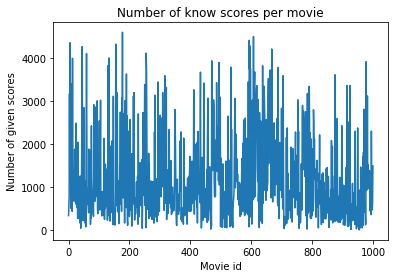

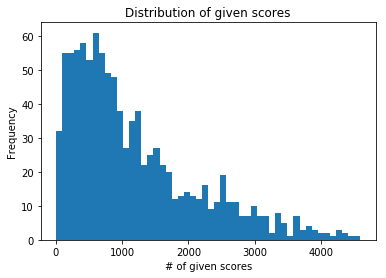

Number of movies unlabeled:  0


In [11]:
plt.plot(existing_labels)
plt.title('Number of know scores per movie')
plt.xlabel('Movie id')
plt.ylabel('Number of given scores')
plt.show()
plt.hist(existing_labels,bins=50)
plt.title('Distribution of given scores')
plt.xlabel('# of given scores')
plt.ylabel('Frequency')
plt.show()
print('Number of movies unlabeled: ', np.sum(existing_labels==0))

In [12]:
#smart iinitialization
A,B,C=np.linalg.svd(matrix,full_matrices=False)
nb_feature=30
B_reduced=np.sqrt(np.diag(B[:nb_feature]))

X=A[:,:nb_feature].dot(B_reduced)
Y=B_reduced.dot(C[:nb_feature,:])

In [12]:
def ALS(X,Y,matrix,label_positions,lambda_1=.01,lambda_2=0.1):
    #fixing Y, optimizing X
    Xnew=X.copy()
    Ynew=Y.copy()
    n_feature=X.shape[1]
    I=np.diag(np.ones((n_feature,)))
    for u in range(X.shape[0]):
        ratings_user=matrix[u,:]
        W_user=np.diag(label_positions[u,:].squeeze())
        A=np.linalg.inv(Y.dot(W_user).dot(Y.T)+lambda_1*I)
        Xnew[u,:]=ratings_user.dot(W_user).dot(Y.T).dot(A.T)
        
#         if u%100==0:
#             print(str(u/100) +'per2cent done')
    for m in range(Y.shape[1]):
        ratings_movie=matrix[:,m]
        W_movie=np.diag(label_positions[:,m].squeeze())
        A=np.linalg.inv(Xnew.T.dot(W_movie).dot(Xnew)+lambda_2*I)
        Ynew[:,m]=A.dot(Xnew.T).dot(W_movie).dot(ratings_movie)
#         if m%10==0:
#             print(str(m/10)+'per2cent done')
    return Xnew,Ynew
        
        
        

In [13]:
def ALS_2(X,Y,matrix,label_positions,lambda_1=.01,lambda_2=0.1):
    #fixing Y, optimizing X
    Xnew=X.copy()
    Ynew=Y.copy()
    n_feature=X.shape[1]
    I=np.diag(np.ones((n_feature,)))
    for u in range(X.shape[0]):
        ratings_user=matrix[u,:]
        W_user=np.diag(label_positions[u,:].squeeze())
        nb_user=np.sum(W_user)
        A=np.linalg.inv(Y.dot(W_user).dot(Y.T)+nb_user*lambda_1*I)
        Xnew[u,:]=ratings_user.dot(W_user).dot(Y.T).dot(A.T)
        
#         if u%100==0:
#             print(str(u/100) +'per2cent done')
    for m in range(Y.shape[1]):
        ratings_movie=matrix[:,m]
        W_movie=np.diag(label_positions[:,m].squeeze())
        nb_movie=np.sum(W_movie)
        A=np.linalg.inv(Xnew.T.dot(W_movie).dot(Xnew)+nb_movie*lambda_2*I)
        Ynew[:,m]=A.dot(Xnew.T).dot(W_movie).dot(ratings_movie)
#         if m%10==0:
#             print(str(m/10)+'per2cent done')
    return Xnew,Ynew

In [25]:
%%time
Xnew,Ynew=ALS(X,Y,matrix,label_positions,lambda_=.1)

Wall time: 16min 3s


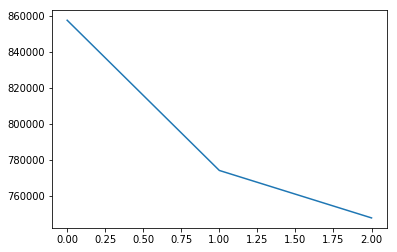

In [309]:
plt.plot(np.array([compute_error(Xnew,Ynew,matrix,label_positions),compute_error(Xnew2,Ynew2,matrix,label_positions),compute_error(Xnew3,Ynew3,matrix,label_positions)]))

In [14]:
dataset_to_predict = pd.read_csv(DATAPATH+"cleaned_sample.csv", names="user_id,movie_id,prediction".split(','))
dataset_to_predict ['user_id'] = dataset_to_predict ['user_id']-1
dataset_to_predict ['movie_id'] = dataset_to_predict ['movie_id']-1
dataset_to_predict .head()

,user_id,movie_id,prediction
0,36,0,3
1,72,0,3
2,155,0,3
3,159,0,3
4,247,0,3


In [27]:
res_matrix=np.round(np.dot(Xnew3,Ynew3))
res_matrix[res_matrix>5]=5
res_matrix[res_matrix<1]=1
matrix_pd = pd.DataFrame(res_matrix)


matrix_pd.index.name = "user_id"
matrix_pd.columns.name="movie_id"
# joined = dataset_to_predict.set_index("user_id").join(matrix_pd,how="outer")

matrix_pd.head()

NameError: name 'Xnew3' is not defined

In [313]:
res=matrix_pd.stack().to_frame().reset_index(level=["user_id","movie_id"])
res.columns=["user_id","movie_id","final_predictions"]
predictors=pd.merge(dataset_to_predict,res,right_on=['user_id','movie_id'],left_on=['user_id','movie_id'],how='inner')


In [314]:
predictors=predictors.drop(columns=['prediction'])

In [315]:
predictors.columns=['user_id','movie_id','predictions']

In [15]:
def create_submission(predictors,name):

    f = open(DATAPATH+name, "w")
    f.write("Id,Prediction\n")
    for _,d in predictors.iterrows():
        text = 'r'+str(int(d[0]+1))+'_c'+str(int(d[1]+1))+','+str(int(d[2]))+'\n'
        f.write(text)
    f.close()

In [16]:
def compute_error(X,Y,matrix,label_pos):

    return np.sum((label_pos * (matrix - np.dot(X, Y)))**2)/np.sum(label_pos)

In [17]:
dataset_to_predict.merge(res,right_on=['user_id','movie_id'],left_on=['user_id','movie_id'],how='inner')

NameError: name 'res' is not defined

In [17]:
def piping(matrix,test_matrix,nb_feature,label_pos,test_pos,dataset_to_predict,lambda_1,lambda_2,iterations,name):
    
    A,B,C=np.linalg.svd(matrix,full_matrices=False)
 
    B_reduced=np.sqrt(np.diag(B[:nb_feature]))

    X=A[:,:nb_feature].dot(B_reduced)
    Y=B_reduced.dot(C[:nb_feature,:])
    
    
    
    X_=X.copy()
    Y_=Y.copy()
    training_errors=[]
    test_errors=[]
    for i in range(iterations):
        X_,Y_=ALS_2(X_,Y_,matrix,label_pos,lambda_1,lambda_2)
        
        res_matrix=np.round(np.dot(X_,Y_))
        res_matrix[res_matrix>5]=5
        res_matrix[res_matrix<1]=1
        training_errors.append(compute_error(X_,Y_,matrix,label_pos))
        test_errors.append(compute_error(X_,Y_,test_matrix,test_pos))
        print('iteration ',i,'lambda 1',lambda_1,'lambda2 ',lambda_2,'errors',compute_error(X_,Y_,matrix,label_pos),' ',compute_error(X_,Y_,test_matrix,test_pos))
#     res_matrix=np.round(np.dot(X_,Y_))
#     res_matrix[res_matrix>5]=5
#     res_matrix[res_matrix<1]=1
    matrix_pd = pd.DataFrame(res_matrix)


    matrix_pd.index.name = "user_id"
    matrix_pd.columns.name="movie_id"
    
    res=matrix_pd.stack().to_frame().reset_index(level=["user_id","movie_id"])
    res.columns=["user_id","movie_id","final_predictions"]
    predictors= pd.merge(dataset_to_predict,res,right_on=['user_id','movie_id'],left_on=['user_id','movie_id'],how='inner')
    plt.plot(np.array(training_errors))
    plt.plot(np.array(test_errors))
    predictors=predictors.drop(columns=['prediction'])
    create_submission(predictors,name)
    
    

In [ ]:
piping(matrix,test_matrix,3,label_positions,test_label_positions,dataset_to_predict,0.001,0.01,10,"3featsALS22.csv")

In [ ]:
piping(matrix,test_matrix,3,label_positions,test_label_positions,dataset_to_predict,0.01,0.1,10,"3featsALS222.csv")

In [ ]:
piping(matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,0.0001,0.002154434690031882,10,"test.csv")

iteration  0 lambda 1 0.0001 lambda2  0.002154434690031882 errors 0.9537637961862865   0.9994631165220458
iteration  1 lambda 1 0.0001 lambda2  0.002154434690031882 errors 0.9256089834438694   0.9860959387820747
iteration  2 lambda 1 0.0001 lambda2  0.002154434690031882 errors 0.921725835639354   0.9852922599161337
iteration  3 lambda 1 0.0001 lambda2  0.002154434690031882 errors 0.9198257669096053   0.9848551775066392


iteration  0 lambda 1 3.1622776601683795 lambda2  3.1622776601683795 errors 0.9573856262682623   0.9957465007304828
iteration  1 lambda 1 3.1622776601683795 lambda2  3.1622776601683795 errors 0.9336809169933148   0.9831618103955226
iteration  2 lambda 1 3.1622776601683795 lambda2  3.1622776601683795 errors 0.9304375263403843   0.9822537889559413
iteration  3 lambda 1 3.1622776601683795 lambda2  3.1622776601683795 errors 0.9282500221900176   0.9813123391700361
iteration  4 lambda 1 3.1622776601683795 lambda2  3.1622776601683795 errors 0.9263928981296339   0.9802062402773927
iteration  0 lambda 1 3.1622776601683795 lambda2  6.812920690579611 errors 0.9589217536566654   0.9967947566242562
iteration  1 lambda 1 3.1622776601683795 lambda2  6.812920690579611 errors 0.9341051566086811   0.9826463584478011
iteration  2 lambda 1 3.1622776601683795 lambda2  6.812920690579611 errors 0.930325437403586   0.981042696175213
iteration  3 lambda 1 3.1622776601683795 lambda2  6.812920690579611 errors 0.

iteration  2 lambda 1 31.622776601683793 lambda2  14.67799267622069 errors 0.9509640272321357   0.987204665465462
iteration  3 lambda 1 31.622776601683793 lambda2  14.67799267622069 errors 0.9467762412021326   0.9847125462577551
iteration  4 lambda 1 31.622776601683793 lambda2  14.67799267622069 errors 0.944578132400391   0.9830504617426865
iteration  0 lambda 1 31.622776601683793 lambda2  31.622776601683793 errors 1.0082112625292001   1.0379056387425525
iteration  1 lambda 1 31.622776601683793 lambda2  31.622776601683793 errors 0.97381133098028   1.0049607471042885
iteration  2 lambda 1 31.622776601683793 lambda2  31.622776601683793 errors 0.9623876158389477   0.994702229128729
iteration  3 lambda 1 31.622776601683793 lambda2  31.622776601683793 errors 0.9578582777531981   0.9908748828584787
iteration  4 lambda 1 31.622776601683793 lambda2  31.622776601683793 errors 0.9558621623967175   0.989115334976525


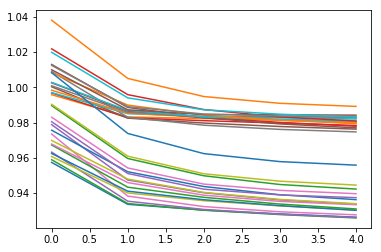

In [18]:
for lambda_1 in np.logspace(0.5,1.5,4):
    for lambda_2 in np.logspace(1.,1.7,4):

        piping(matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,lambda_1,lambda_2,5,"test.csv")

iteration  0 lambda 1 3.1622776601683795 lambda2  10.0 errors 0.9605636045228422   0.9980715962064086
iteration  1 lambda 1 3.1622776601683795 lambda2  10.0 errors 0.9346196027005587   0.9824967637415981
iteration  2 lambda 1 3.1622776601683795 lambda2  10.0 errors 0.9304518080048272   0.9803757555274885
iteration  3 lambda 1 3.1622776601683795 lambda2  10.0 errors 0.9278650639135012   0.9787138844892016
iteration  4 lambda 1 3.1622776601683795 lambda2  10.0 errors 0.9259859224842402   0.9772914857072214
iteration  0 lambda 1 3.1622776601683795 lambda2  17.11328304161781 errors 0.9646666162763586   1.0014423224558293
iteration  1 lambda 1 3.1622776601683795 lambda2  17.11328304161781 errors 0.9358830308918236   0.9825109967857214
iteration  2 lambda 1 3.1622776601683795 lambda2  17.11328304161781 errors 0.9309990290353005   0.9794120038519541
iteration  3 lambda 1 3.1622776601683795 lambda2  17.11328304161781 errors 0.9282242413935707   0.977359859364306
iteration  4 lambda 1 3.1622776

iteration  4 lambda 1 15.848931924611133 lambda2  29.286445646252357 errors 0.9424949144786332   0.9810228564633373
iteration  0 lambda 1 15.848931924611133 lambda2  50.11872336272722 errors 1.0060788157900318   1.0374891962366266
iteration  1 lambda 1 15.848931924611133 lambda2  50.11872336272722 errors 0.9677058389361605   1.0018275745952012
iteration  2 lambda 1 15.848931924611133 lambda2  50.11872336272722 errors 0.9568481088527189   0.9914502340392739
iteration  3 lambda 1 15.848931924611133 lambda2  50.11872336272722 errors 0.9522517587461231   0.9870928465828903
iteration  4 lambda 1 15.848931924611133 lambda2  50.11872336272722 errors 0.9502088255455797   0.9851672519740844


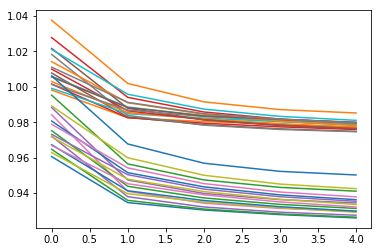

In [19]:
for lambda_1 in np.logspace(0.5,1.2,4):
    for lambda_2 in np.logspace(1.,1.7,4):

        piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,lambda_1,lambda_2,5,"test.csv")

iteration  0 lambda 1 1.9952623149688795 lambda2  31.622776601683793 errors 0.9718734206721914   1.0079390653626419
iteration  1 lambda 1 1.9952623149688795 lambda2  31.622776601683793 errors 0.9350444949586054   0.9810345386486232
iteration  2 lambda 1 1.9952623149688795 lambda2  31.622776601683793 errors 0.9294454076493701   0.9769516061112067
iteration  3 lambda 1 1.9952623149688795 lambda2  31.622776601683793 errors 0.9268468574785176   0.9750696196724968
iteration  4 lambda 1 1.9952623149688795 lambda2  31.622776601683793 errors 0.925404823463386   0.97406072188589
iteration  0 lambda 1 1.9952623149688795 lambda2  42.986623470822764 errors 0.9782961939544426   1.0133839537903004
iteration  1 lambda 1 1.9952623149688795 lambda2  42.986623470822764 errors 0.9366693545911043   0.9814709293707604
iteration  2 lambda 1 1.9952623149688795 lambda2  42.986623470822764 errors 0.9305541919684133   0.9768267080841609
iteration  3 lambda 1 1.9952623149688795 lambda2  42.986623470822764 errors

iteration  2 lambda 1 5.011872336272722 lambda2  58.434141337351754 errors 0.9399288896439641   0.981041279716106
iteration  3 lambda 1 5.011872336272722 lambda2  58.434141337351754 errors 0.9366166326931473   0.9780507912554146
iteration  4 lambda 1 5.011872336272722 lambda2  58.434141337351754 errors 0.9348952740312301   0.9765064921973944
iteration  0 lambda 1 5.011872336272722 lambda2  79.43282347242814 errors 1.00351483770697   1.035388958538578
iteration  1 lambda 1 5.011872336272722 lambda2  79.43282347242814 errors 0.9505663531517206   0.9892248892732568
iteration  2 lambda 1 5.011872336272722 lambda2  79.43282347242814 errors 0.9427765347152737   0.9821694956282827
iteration  3 lambda 1 5.011872336272722 lambda2  79.43282347242814 errors 0.9397433365732218   0.9793855565765804
iteration  4 lambda 1 5.011872336272722 lambda2  79.43282347242814 errors 0.9382799330478244   0.9780790498030003


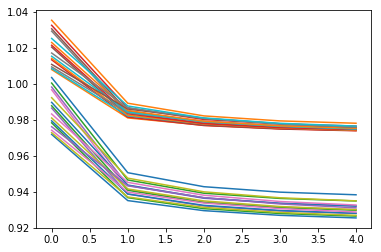

In [20]:
for lambda_1 in np.logspace(0.3,0.7,4):
    for lambda_2 in np.logspace(1.5,1.9,4):

        piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,lambda_1,lambda_2,5,"test.csv")

iteration  0 lambda 1 10.0 lambda2  10.0 errors 0.9675685497424412   1.0018108032467203
iteration  1 lambda 1 10.0 lambda2  10.0 errors 0.9460278229082807   0.9870320561451457
iteration  2 lambda 1 10.0 lambda2  10.0 errors 0.9395263153721293   0.9832304182094713
iteration  3 lambda 1 10.0 lambda2  10.0 errors 0.9354114241397906   0.9810643758602733
iteration  4 lambda 1 10.0 lambda2  10.0 errors 0.9325470900458787   0.9792018277011539
iteration  5 lambda 1 10.0 lambda2  10.0 errors 0.9304253924729508   0.9774535511440404
iteration  6 lambda 1 10.0 lambda2  10.0 errors 0.9288221997984668   0.9759765373694531
iteration  7 lambda 1 10.0 lambda2  10.0 errors 0.9276373687337086   0.9748718888565294
iteration  8 lambda 1 10.0 lambda2  10.0 errors 0.9267946796561097   0.974122827885075
iteration  9 lambda 1 10.0 lambda2  10.0 errors 0.926216507321817   0.9736497723318718
iteration  0 lambda 1 1.9952623149688795 lambda2  42.986623470822764 errors 0.9782961939544426   1.0133839537903004
iterat

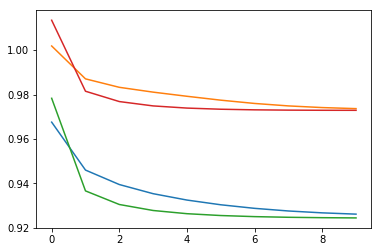

In [21]:
piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,10.,10.,10,"test.csv")
piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,1.9952623149688795,42.986623470822764,10,"test.csv")

iteration  0 lambda 1 10.0 lambda2  10.0 errors 0.9675685497424412   1.0018108032467203
iteration  1 lambda 1 10.0 lambda2  10.0 errors 0.9460278229082807   0.9870320561451457
iteration  2 lambda 1 10.0 lambda2  10.0 errors 0.9395263153721293   0.9832304182094713
iteration  3 lambda 1 10.0 lambda2  10.0 errors 0.9354114241397906   0.9810643758602733
iteration  4 lambda 1 10.0 lambda2  10.0 errors 0.9325470900458787   0.9792018277011539
iteration  5 lambda 1 10.0 lambda2  10.0 errors 0.9304253924729508   0.9774535511440404
iteration  6 lambda 1 10.0 lambda2  10.0 errors 0.9288221997984668   0.9759765373694531
iteration  7 lambda 1 10.0 lambda2  10.0 errors 0.9276373687337086   0.9748718888565294
iteration  8 lambda 1 10.0 lambda2  10.0 errors 0.9267946796561097   0.974122827885075
iteration  9 lambda 1 10.0 lambda2  10.0 errors 0.926216507321817   0.9736497723318718
iteration  10 lambda 1 10.0 lambda2  10.0 errors 0.9258292605910883   0.973364642669293
iteration  11 lambda 1 10.0 lambda

iteration  18 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.925772287662202   0.9730660637639557
iteration  19 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.9257773800682818   0.9730787145789271
iteration  20 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.9257824208812582   0.9730897702338592
iteration  21 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.9257873335273574   0.9730994870198888
iteration  22 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.9257920844116314   0.9731080909499026
iteration  23 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.925796663573682   0.9731157748058114
iteration  24 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.9258010734257981   0.9731226995304489
iteration  25 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.9258053222996288   0.9731289975627915
iteration  26 lambda 1 2.712272579332028 lambda2  42.986623470822764 error

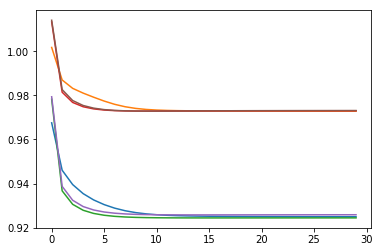

In [22]:
piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,10.,10.,30,"test.csv")
piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,1.9952623149688795,42.986623470822764,30,"test.csv")
piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,2.712272579332028,42.986623470822764,30,"test.csv")

In [ ]:
piping(matrix,test_matrix,3,label_positions,test_label_positions,dataset_to_predict,1.,10.,30,"aveMaria2.csv")

iteration  0 lambda 1 1.0 lambda2  10.0 errors 0.9583583670368065   0.9534440012077696
iteration  1 lambda 1 1.0 lambda2  10.0 errors 0.9304790665082934   0.9242835163711776
iteration  2 lambda 1 1.0 lambda2  10.0 errors 0.9264827009856864   0.9200885457684405
iteration  3 lambda 1 1.0 lambda2  10.0 errors 0.9246783888335558   0.9182689801399688
iteration  4 lambda 1 1.0 lambda2  10.0 errors 0.9237481492868322   0.9173469567654225
iteration  5 lambda 1 1.0 lambda2  10.0 errors 0.9232269695395792   0.9168287855719625
iteration  6 lambda 1 1.0 lambda2  10.0 errors 0.9229146567982274   0.9165142195732731
iteration  7 lambda 1 1.0 lambda2  10.0 errors 0.9227155441676096   0.9163105366483738
iteration  8 lambda 1 1.0 lambda2  10.0 errors 0.9225810724535844   0.9161711985045506
iteration  9 lambda 1 1.0 lambda2  10.0 errors 0.9224854846983584   0.9160714938083941
iteration  10 lambda 1 1.0 lambda2  10.0 errors 0.9224145360647963   0.9159975968797391
iteration  11 lambda 1 1.0 lambda2  10.0 e

In [ ]:
piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,2.712272579332028,1.0,30,"test.csv")

In [ ]:
#iteration  4 lambda 1 1.9952623149688795 lambda2  42.986623470822764 errors 0.9264181105599623 
iteration  4 lambda 1 2.712272579332028 lambda2  42.986623470822764 errors 0.9279818435374766   0.974241222880232
for lambda_1 in np.logspace(-2,1,4):
    for lambda_2 in np.logspace(-2,1,4):

        piping(train_matrix,test_matrix,3,train_label_positions,test_label_positions,dataset_to_predict,1.9952623149688795,42.986623470822764,10,"test.csv")

iteration  0 lambda 1 0.01 lambda2  0.01 errors 0.9547448734835797   0.9985097331980627
iteration  1 lambda 1 0.01 lambda2  0.01 errors 0.9262715318042506   0.9853493771863209
iteration  2 lambda 1 0.01 lambda2  0.01 errors 0.9224299485148422   0.9837752804939495
iteration  3 lambda 1 0.01 lambda2  0.01 errors 0.9204715613362152   0.9825686367592072
iteration  4 lambda 1 0.01 lambda2  0.01 errors 0.9194805958879771   0.9817889878802669
iteration  5 lambda 1 0.01 lambda2  0.01 errors 0.9189895131540569   0.9813596605590348
iteration  6 lambda 1 0.01 lambda2  0.01 errors 0.918746102546233   0.9811392828491715
iteration  7 lambda 1 0.01 lambda2  0.01 errors 0.9186242055376314   0.9810284338791891
iteration  8 lambda 1 0.01 lambda2  0.01 errors 0.9185624800587076   0.9809731438314554
iteration  9 lambda 1 0.01 lambda2  0.01 errors 0.9185308514007205   0.9809448896137665
iteration  0 lambda 1 0.01 lambda2  0.1 errors 0.9547471525694011   0.9985027272028145
iteration  1 lambda 1 0.01 lambda2

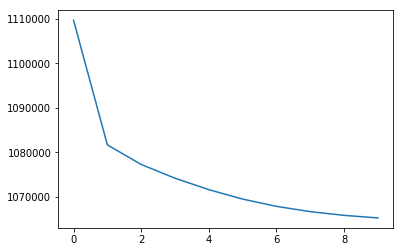

In [17]:
piping(matrix,4,label_positions,dataset_to_predict,5.,10,"10pass4feat_lambda5Dot.csv")

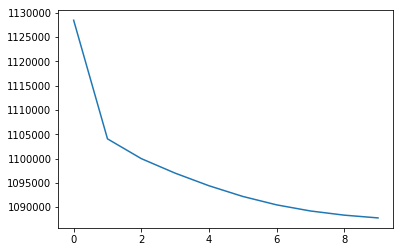

In [18]:
piping(matrix,3,label_positions,dataset_to_predict,5.,10,"10pass3feat_lambda5Dot.csv")

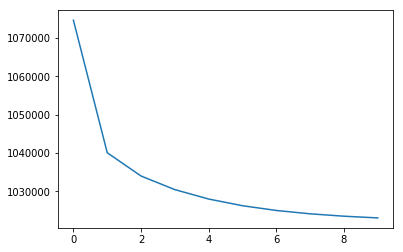

In [19]:
piping(matrix,6,label_positions,dataset_to_predict,5.,10,"10pass6feat_lambda5Dot.csv")

CPU times: user 5h 22min 38s, sys: 2h 3min, total: 7h 25min 38s
Wall time: 2h 6min 35s


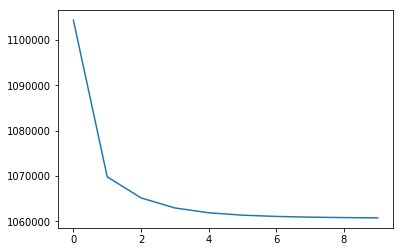

In [17]:
%%time
piping(matrix,4,label_positions,dataset_to_predict,.1,10,"10pass4feat_lambdaDot1.csv")

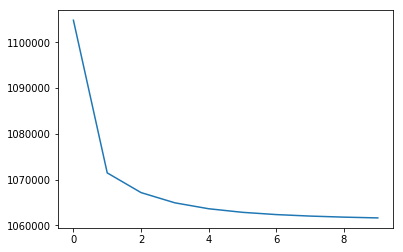

In [18]:
piping(matrix,4,label_positions,dataset_to_predict,1.,10,"10pass4feat_lambda1Dot.csv")

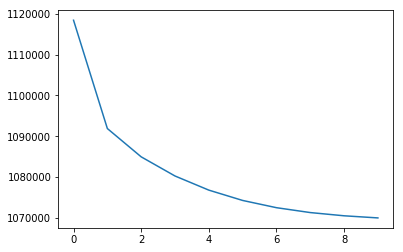

In [19]:
piping(matrix,4,label_positions,dataset_to_predict,10.,10,"10pass3feat_lambda10Dot.csv")

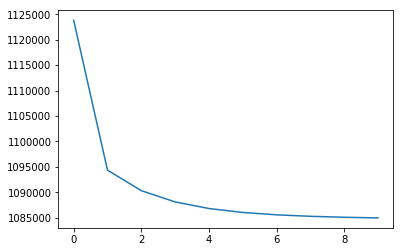

In [17]:
piping(matrix,3,label_positions,dataset_to_predict,1.,10,"10pass3feat_lambda1Dot.csv")

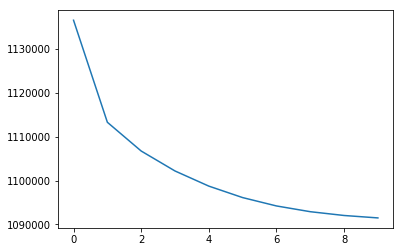

In [18]:
piping(matrix,3,label_positions,dataset_to_predict,10.,10,"10pass3feat_lambda10Dot.csv")

## studies on small matrix

In [245]:
study_matrix=np.array([[0,2,3],[4,0,6],[7,8,9]])
study_label=study_matrix>0
#smart iinitialization
A,B,C=np.linalg.svd(study_matrix,full_matrices=False)
nb_feature=2
B_reduced=np.sqrt(np.diag(B[:nb_feature]))

X=A[:,:nb_feature].dot(B_reduced)
Y=B_reduced.dot(C[:nb_feature,:])
print(X.dot(Y))

[[ 1.45580721e+00  1.93264315e+00  2.01068789e+00]
 [ 4.05285407e+00 -2.44543593e-03  5.96408235e+00]
 [ 6.64903407e+00  8.01623839e+00  9.23850332e+00]]


In [246]:
X_new,Y_new=ALS(X,Y,study_matrix,study_label,lambda_=.01)
print(study_label)

percent done
percent done
[[False  True  True]
 [ True False  True]
 [ True  True  True]]


percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done

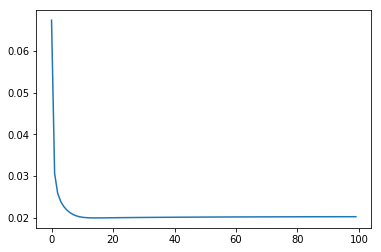

In [249]:
X_old=X.copy()
Y_old=Y.copy()
error=[]
for i in range(100):
    X_new,Y_new=ALS(X_old,Y_old,study_matrix,study_label,lambda_=.1)
    #print(X_new.dot(Y_new)
    X_old=X_new.copy()
    Y_old=Y_new.copy()
    error.append(compute_error(X_new,Y_new,study_matrix,study_label))
plt.plot(error)
print(X_old.dot(Y_old))

In [158]:
X_new=X
Y_new=Y
for i in range(10):
    X_new,Y_new=ALS2(X_new,Y_new,study_matrix,study_label,lambda_=.01)
    print(X_new.dot(Y_new))

percent done
percent done
[[-1.10684842  2.00138817  2.99304408]
 [ 3.77603079  1.07015564  5.98995107]
 [ 7.11638927  0.8960582   8.98976896]]
percent done
percent done
[[0.04126691 1.97702348 3.00246583]
 [4.16101385 0.94561267 5.99832886]
 [6.90551976 0.93021356 8.99878779]]
percent done
percent done
[[-0.82483707  2.00124432  2.99259745]
 [ 3.81052961  1.08583997  5.99036155]
 [ 7.0912223   0.89668332  8.99188542]]
percent done
percent done
[[0.11036948 1.97731763 3.0030274 ]
 [4.14403434 0.97700731 5.99741552]
 [6.91836703 0.93437289 8.99733359]]
percent done
percent done
[[-0.6096168   2.00101594  2.99208888]
 [ 3.83557188  1.10827919  5.99101507]
 [ 7.07258939  0.91012477  8.99362216]]
percent done
percent done
[[0.17245439 1.97760403 3.00358078]
 [4.13038456 1.006145   5.99660979]
 [6.92895217 0.94008689 8.99600422]]
percent done
percent done
[[-0.43822768  2.00079254  2.99159074]
 [ 3.85468962  1.13016487  5.99157585]
 [ 7.05811083  0.92400719  8.99520696]]
percent done
percen

In [130]:
%%time
Xnew,Ynew=ALS(X,Y,matrix,label_positions)

percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done

In [133]:
compute_error(Xnew,Ynew,matrix,label_positions)

3.6439731618617217

## Found on
https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/